# Signal Processing Project: real-time sound localisation

## 1 Offline system
### 1.1 Data generation and dataset

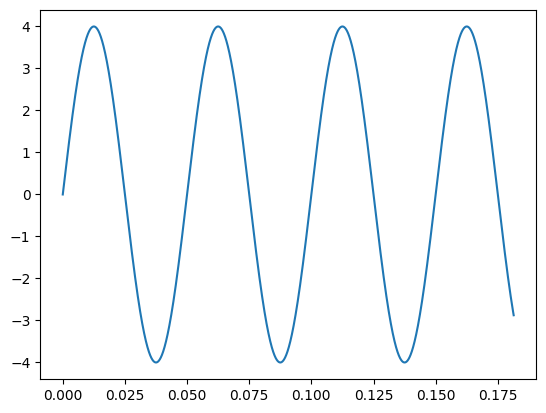

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def create_sine_wave(f, A, fs, N):
    sample = np.arange(N)
    t = sample / fs
    out = A * np.sin(2 * np.pi * f * t)

    return out

# call and test your function here #
fs = 44100
N = 8000
freq = 20
amplitude = 8/2
plt.plot(np.arange(N)/fs, create_sine_wave(freq, amplitude, fs, N))
plt.show()

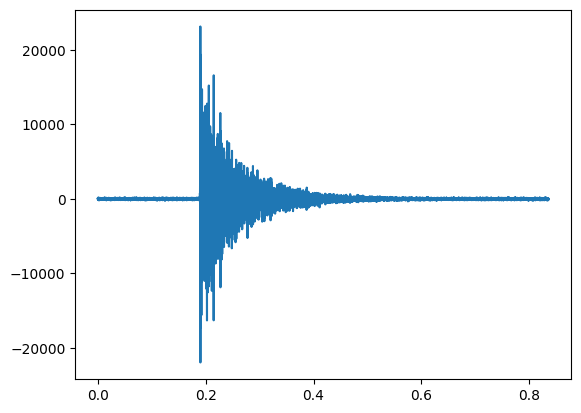

In [44]:
from glob import glob
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt
import numpy as np

def read_wavefile(path):
    fs, data = wf.read(path)
    N = data.shape[0]
    t = np.arange(N) / fs
    
    return fs, t, data

# call and test your function here #
LocateClaps = "LocateClaps/M1_0.wav"
files = glob(f"{LocateClaps}/*.wav")

result = read_wavefile(LocateClaps)

plt.plot(result[1], result[2])
plt.show()


### 1.2 Buffering

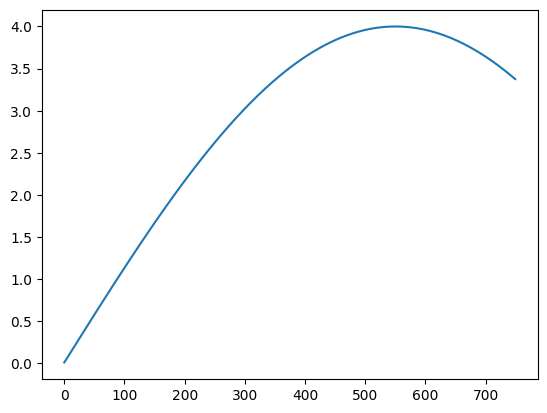

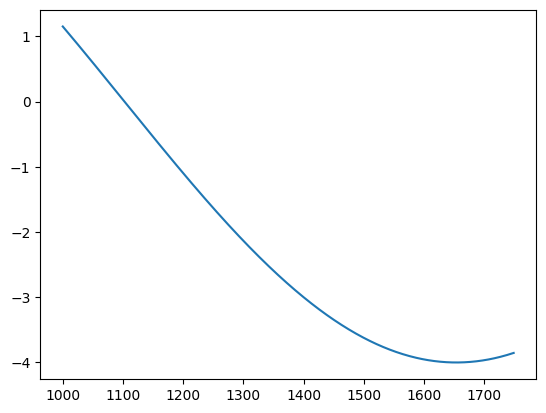

In [95]:
from collections import deque

def create_ringbuffer(maxlen):

    out = deque(maxlen=maxlen)

    return out

# call and test your function here #
stride = 750
maxlen = 750

ringbuffer = create_ringbuffer(maxlen)

# reading your signal as a stream:
for i, sample in enumerate(create_sine_wave(20, 8/2, 44100, 8000)):
    ringbuffer.append(sample)
    if i == maxlen:
        plt.plot(ringbuffer)
        plt.show() 

    if i == 1749:
        plt.plot(np.arange(stride) + 1000 ,ringbuffer)
        plt.show()    

                

### 1.3 Pre-processing
#### 1.3.1 Normalisation

In [ ]:
def normalise(s):
    
    # your code here #

    return out

# call and test your function here #

#### 1.3.2 Downsampling

In [ ]:
## 1 - spectral analysis via spectrogram
plt.specgram( , Fs= )
plt.title("Spectrogram")
plt.show()

## 2 - Anti-aliasing filter synthesis
def create_filter_cheby(wp, ws, gpass, gstop, fs):

    # your code here #

    return B, A

def create_filter_cauer(wp, ws, gpass, gstop, fs):

    # your code here #

    return B, A

## 3 - Decimation
def downsampling(sig, B, A, M):

    # your code here #

    return out


# call and test your function here

### 1.4 Cross-correlation

In [ ]:
## 1.4
import scipy.signal as sc
import numpy as np

def fftxcorr(in1, in2):
    
    # your code here #

    return out
    
# call and test your function here #

xcorr_fftconv = sc.fftconvolve(your_signal, your_signal[::-1], 'full') # [::-1] flips the signal but you can also use np.flip()

### 1.5 Localisation
#### 1.5.1 TDOA

In [ ]:
def TDOA(xcorr):
    
    # your code here #

    return out

#### 1.5.2 Equation system

In [ ]:
from scipy.optimize import root

# mic coordinates in meters
MICS = [{'x': 0, 'y': 0.0487}, {'x': 0.0425, 'y': -0.025}, {'x': -0.0425, 'y': -0.025}] 

def equations(p, deltas):
    v = 343
    x, y = p
    eq1 = v*deltas[0] - np.sqrt((MICS[0]['x'] - x)**2 + (MICS[0]['y'] - y)**2) + np.sqrt((MICS[1]['x'] - x)**2 + (MICS[1]['y'] - y)**2)
    eq2 = v*deltas[1] - np.sqrt((MICS[0]['x'] - x)**2 + (MICS[0]['y'] - y)**2) + np.sqrt((MICS[2]['x'] - x)**2 + (MICS[2]['y'] - y)**2)
    return (eq1, eq2)
    
def localize_sound(deltas):

    sol = root(equations, [0, 0], (deltas), tol=10)
    return sol.x

def source_angle(coordinates):
    
    # your code here

    return out

# call and test your function here #

### 1.6 System accuracy and speed

In [2]:
## 1.6.1
def accuracy(pred_angle, gt_angle, threshold):
    
    # your code here #

    return out

## 1.6.2
possible_angle = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
for angle in possible_angle:
    for f in files:
        if f'_{angle}.' in f:
            mic = f.split('/')[-1].split('_')[0] #if '/' does not work, use "\\" (windows notation)
            
# call and test your function here #

## 1.6.3
from time import time_ns, sleep

def func_example(a, b):
    return a*b

def time_delay(func, args):
    start_time = time_ns()
    out = func(*args)
    end_time = time_ns()
    print(f"{func.__name__} in {end_time - start_time} ns")
    return out

product = time_delay(func_example, [2, 10])

# call and test your previous functions here #

## 2 Real-time localisation

### 2.1 Research one Raspberry Pi application

### 2.2 Data acquisition and processing

In [ ]:
#### Callback 
import pyaudio

RESPEAKER_CHANNELS = 8
BUFFERS = []

def callback(in_data, frame_count, time_info, flag):
    global BUFFERS
    data = np.frombuffer(in_data, dtype=np.int16)
    BUFFERS[0].extend(data[0::RESPEAKER_CHANNELS])
    BUFFERS[1].extend(data[2::RESPEAKER_CHANNELS])
    BUFFERS[2].extend(data[4::RESPEAKER_CHANNELS])
    return (None, pyaudio.paContinue)

#### Stream management

RATE = 44100
RESPEAKER_WIDTH = 2
CHUNK_SIZE = 2048

def init_stream():
    print("========= Stream opened =========")
    p = pyaudio.PyAudio()
    for i in range(p.get_device_count()):
        device_info = p.get_device_info_by_index(i)

        if device_info['maxInputChannels'] == 8:
            INDEX = i
            break

        if i == p.get_device_count()-1:
            # Sound card not found
            raise OSError('Invalid number of channels')

    stream = p.open(rate=RATE, channels=RESPEAKER_CHANNELS, format=p.get_format_from_width(RESPEAKER_WIDTH), input=True, input_device_index=INDEX,
                    frames_per_buffer=CHUNK_SIZE, stream_callback=callback)

    return stream



def close_stream(stream):
    print("========= Stream closed =========")
    stream.stop_stream()
    stream.close()

#### Detection and visual feedback
def detection(stream):
    global BUFFERS, pixel_ring
    
    if stream.is_active():
        print("========= Recording =========")

    while stream.is_active():
        try:
            if len(BUFFERS[0]) > CHUNK_SIZE:
                st = time_ns()
                deltas = [TDOA(fftxcorr(BUFFERS[0], BUFFERS[1])), TDOA(fftxcorr(BUFFERS[0], BUFFERS[2]))] 

                x, y = localize_sound(deltas)
                hyp = np.sqrt(x**2+y**2)
                
                ang_cos = round(np.arccos(x/hyp)*180/np.pi, 2)
                ang_sin = round(np.arcsin(y/hyp)*180/np.pi, 2)

                if ang_cos == ang_sin:
                    ang = ang_cos
                else:
                    ang = np.max([ang_cos, ang_sin])
                    if ang_cos < 0 or ang_sin < 0:
                        ang *= -1
                ang *= -1

                print((time_ns() - st)/1e9, ang)

                print(np.max(BUFFERS, axis=-1))

                if (np.max(BUFFERS, axis=-1) > 3000).any():
                    pixel_ring.wakeup(ang)
                else:
                    pixel_ring.off()

                sleep(0.5)

        except KeyboardInterrupt:
            print("========= Recording stopped =========")
            break

#### Launch detection
from pixel_ring.apa102_pixel_ring import PixelRing
from gpiozero import LED


USED_CHANNELS = 3


power = LED(5)
power.on()

pixel_ring = PixelRing(pattern='soundloc')

pixel_ring.set_brightness(10)

for i in range(USED_CHANNELS):
    BUFFERS.append(create_ringbuffer(3 * CHUNK_SIZE))
    
stream = init_stream()

while True:
    try:
        detection(stream)
        sleep(0.5)
    except KeyboardInterrupt:
        break

close_stream(stream)

power.off()